# These are some plots where h was a small value = 5 x 10^-15

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

In [37]:

import matplotlib.pyplot as plt 
from priors import priors_dict
import numpy as np 
import json
import pandas as pd 
import corner
import scienceplots

def load_data(path,variables_to_plot):


    try:
        df_posterior = pd.read_parquet(path)  

    except:
        # Opening JSON file
        f = open(path)
        data = json.load(f)
        f.close()
        #Make it a dataframe. 
        df_posterior = pd.DataFrame(data["posterior"]["content"]) 


    #Make omega into nHz
    df_posterior["omega_gw"] = df_posterior["omega_gw"]*1e9
    df_posterior["h"] = df_posterior["h"]*1e12

    y_post = df_posterior[variables_to_plot].to_numpy()

    # print("Number of samples:",len(df_posterior))
    # print("Truths/Medians/Variances")
    medians = df_posterior[variables_to_plot].median()
    variances = df_posterior[variables_to_plot].var()
    q = [0.05,0.95]
    for i in range(len(medians)):
        print(variables_to_plot[i],medians[i],variances[i])
        print("quantiles:", np.quantile(df_posterior[variables_to_plot[i]],q))
    



    return_code = 0


    extra_median = df_posterior['psi_gw'].median()
    #if extra_median < 1.0: #psi is weird / not converged so don't plot it 
       # print("Ignoring this file since psi not converged",extra_median)
       # return_code = 1
        
    print('-----------------------------***********************----------------------')
    return y_post, return_code







from parse import * 


def drop_braces(string_object):

    string_object = string_object.replace('{', '')
    string_object = string_object.replace('}', '')
    return string_object


def extract_value_from_title(title_string):

    template = '$\\{param_name}$ = ${value}_{lower}^{upper}$'

    parsed_output = parse(template, title_string)

    if parsed_output is None: #Handles h which is not a greek letter
        template = '${param_name}$ = ${value}_{lower}^{upper}$'
        parsed_output = parse(template, title_string)



    

    return parsed_output['param_name'],drop_braces(parsed_output['value']),drop_braces(parsed_output['lower']),drop_braces(parsed_output['upper'])

#https://stackoverflow.com/questions/32923605/is-there-a-way-to-get-the-index-of-the-median-in-python-in-one-command
def argmedian(x):
  return np.argpartition(x, len(x) // 2)[len(x) // 2]

def stacked_corner(list_of_files,number_of_files_to_plot,variables_to_plot,ranges,injection_parameters,labels,axes_scales,savefig=None,logscale=False):




    

    y = []
    fig= None 
    i = 0

    #while i < number_of_files_to_plot:

    for j in range(len(list_of_files)):
        f = list_of_files[j]
        yi,code = load_data(f,variables_to_plot)

        if code == 0:
            y.extend([yi])
            i += 1

        if i > number_of_files_to_plot:
            break
        
        print(i, f)

    plt.style.use('science')

    

    num_params = len(variables_to_plot)
    
    title_values = np.zeros((num_params,number_of_files_to_plot)) #an array with shape number of parameters x number of noise realisations 
    title_upper = np.zeros((num_params,number_of_files_to_plot)) 
    title_lower = np.zeros((num_params,number_of_files_to_plot))

    print("Shape of title value s arary", np.shape(title_values))
    

    for i in range(number_of_files_to_plot): #for each noise realisation 

        k = i 
        if k ==2:
            k = k+1 #convoluted way of skipping C2 color




        if logscale:
            yplot = np.log10(y[i])
            injection_parameters = np.log10(injection_parameters)
            #ranges = np.log10(ranges)
        else:
            yplot = y[i]
        
        print("ranges =", ranges)
        nsamples = len(y[i])
        fs = 20

        new_injection_parameters = [injection_parameters[0]*1e9,injection_parameters[1],injection_parameters[2],injection_parameters[3],injection_parameters[4]]
        



        print("The injection parameters for the plotter are:", new_injection_parameters)
        fig = corner.corner(yplot, 
                            color=f'C{k}',
                            show_titles=True,
                            smooth=True,smooth1d=True,
                            truth_color='C2',
                            quantiles=[0.16, 0.84],
                            truths =new_injection_parameters,
                            range=ranges,
                            labels = labels,
                            label_kwargs=dict(fontsize=fs),
                            axes_scales = axes_scales,
                            weights = np.ones(nsamples)/nsamples,
                            fig=fig)


        kk = 0
        for ax in fig.axes:
            ax_title = ax.get_title()
            
            if ax_title != '':


                #print('2:', ax_title, type(ax_title))
                param_name, value,lower_limit,upper_limit = extract_value_from_title(ax_title) #Get the values that corner.corner sends to the ax title
                #print(parsed_output)

                print(kk,i,param_name,value)
                title_values[kk,i] = value
                title_lower[kk,i] = lower_limit
                title_upper[kk,i] = upper_limit


            
                kk += 1
                


        i += 1


        #Pretty-ify
    for ax in fig.axes:

        if ax.lines: #is anything plotted on this axis?
            
            ax.yaxis.set_major_locator(plt.MaxNLocator(3))
            ax.xaxis.set_major_locator(plt.MaxNLocator(3))

            ax.yaxis.set_tick_params(labelsize=fs-6)
            ax.xaxis.set_tick_params(labelsize=fs-6)


        ax.title.set_size(18)



#     #Get the indices of the median values from the list of medians 
#     idxs = [] #this is the index of the median for each parameter. 
#     for l in range(num_params):
#         idx = argmedian(title_values[l,:])
#         idxs.extend([idx])



#     #Now use it to set the titles
#     kk = 0
#     for ax in fig.axes:
#         ax_title = ax.get_title()
#         if ax_title != '':


#             selected_idx = idxs[kk]

# #foo = f'text$_{{{var}}}$'


#             new_title_string = rf'{labels[kk]} $= {title_values[kk,selected_idx]:.2f}_{{{title_lower[kk,selected_idx]:.2f}}}^{{+{title_upper[kk,selected_idx]:.2f}}}$'
#             print(new_title_string) 
#             ax.set_title(new_title_string, fontsize=18)
#             kk += 1





    if savefig != None:
        plt.savefig(f"../data/images/{savefig}.png", bbox_inches="tight",dpi=300)
        

    #return fig            


# Define data files to use

In [38]:
import glob 
list_of_files = sorted(glob.glob("../data/nested_sampling/data_for_manuscript/pp_plots_small_h/*"))
variables_to_plot = ["omega_gw","phi0_gw","psi_gw","delta_gw","alpha_gw"]


def parse_filename(f):
    row = f.split('_')
    omega,phi0,psi,delta,alpha = row[15],row[17],row[19],row[21],row[23] #specific to these filenames
    return float(omega),float(phi0),float(psi),float(delta),float(alpha)


## Plot just one file to check everything ok 

Injection parameters =  (1.0230135211683393e-08, 0.3704171536650886, 2.8305556812996406, 0.8065654642127479, 1.296128240812015)
omega_gw 10.10882732780101 6.805972919606593
quantiles: [ 5.66631613 14.28526125]
phi0_gw 0.6872874833655938 0.07935497427195971
quantiles: [0.23014825 1.17242072]
psi_gw 2.3188097236629543 0.036005324264973076
quantiles: [2.07952343 2.66554294]
delta_gw 0.9436860505562231 0.007318925943254205
quantiles: [0.83734522 1.10614346]
alpha_gw 0.3180102444359429 0.036685499936785874
quantiles: [0.06737613 0.68164298]
-----------------------------***********************----------------------
1 ../data/nested_sampling/data_for_manuscript/pp_plots_small_h/pp_plot_h_5e-15_model_earth_seed_1237_omega_1.0230135211683393e-08_phi0_0.3704171536650886_psi_2.8305556812996406_delta_0.8065654642127479_alpha_1.296128240812015_result.json
Shape of title value s arary (5, 1)
ranges = [(9.207121690515054, 11.253148732851734), (-3.141592653589793, 3.141592653589793), (0.0, 3.141592653

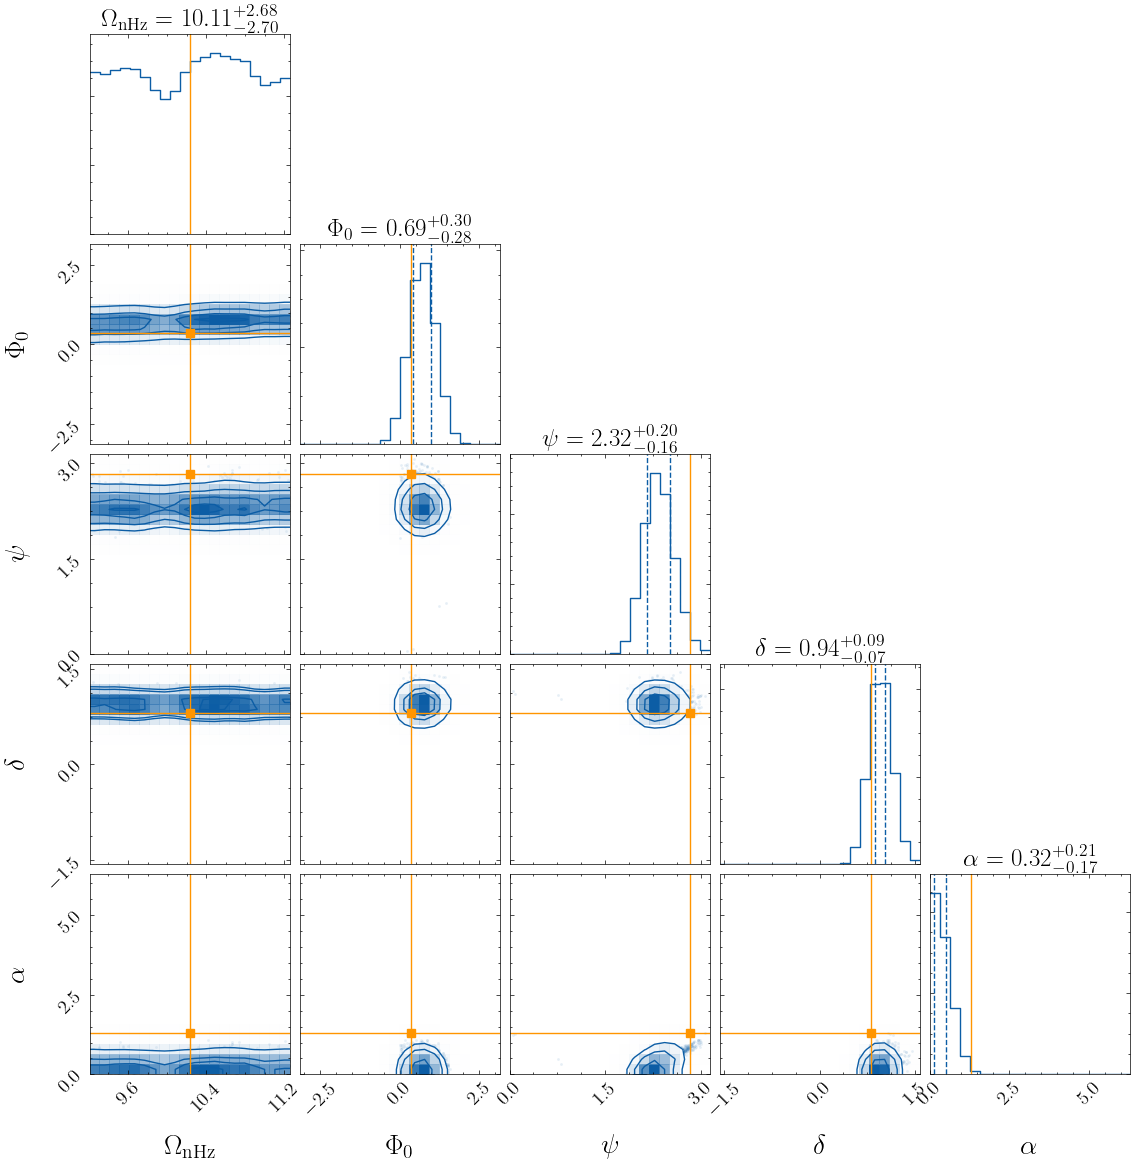

In [78]:
f = list_of_files[1]
injection_parameters = parse_filename(f)
ranges=[(injection_parameters[0]*0.9*1e9,injection_parameters[0]*1.1*1e9),(-np.pi,np.pi),(0.0,np.pi),(-np.pi/2,np.pi/2),(0.0,2*np.pi)]

labels = [r'$\Omega_{\rm nHz}$',r'$\Phi_0$',r'$\psi$', r'$\delta$',r'$\alpha$']
axes_scales = None



print("Injection parameters = ", injection_parameters)
number_of_files_to_plot = 1
stacked_corner([f],number_of_files_to_plot,variables_to_plot,ranges,injection_parameters,labels,axes_scales,savefig=None, logscale=False)


## Now lets look at getting some credible intervals / quantiles 

In [142]:
%%time
quantiles = np.arange(0,1.0,0.05) #[0.05,0.95] #90 per cent quantiles 
quantiles = np.append(quantiles,1.0) #quantiles.append(1.0)
import sys

#q90 = [0.05,0.95]
#q90_results = np.zeros(len(variables_to_plot))

quantile_results = np.zeros((int(len(quantiles)/2),len(variables_to_plot))) #quantile rows x variable columns

for f in list_of_files:
    print(f)
    injection_parameters = parse_filename(f)
    # Load the data into a df
    f = open(f)
    data = json.load(f)
    f.close()
    df_posterior = pd.DataFrame(data["posterior"]["content"])[variables_to_plot] 
    
    #Get the quantiles
    df_quantile = df_posterior.quantile(quantiles)


    #For each quantile pair

    #Special case for i=0
    i=0
    lower_limit = df_quantile.iloc[i] 
    upper_limit = df_quantile.iloc[-1] 
    #print("quantiles", 0,quantiles[i], quantiles[-1],quantiles[-1] -quantiles[i])


    for j in range(len(injection_parameters)):
        var = variables_to_plot[j]
        #print(0, lower_limit[var], injection_parameters[j], upper_limit[var])
        if lower_limit[var] <= injection_parameters[j] <= upper_limit[var]:
            quantile_results[i,j] = quantile_results[i,j] + 1





    for i in range(1,int(len(quantiles)/2)):
        #print("quantiles", i,quantiles[i], quantiles[-i],quantiles[-i] -quantiles[i])

        lower_limit = df_quantile.iloc[i] 
        upper_limit = df_quantile.iloc[-i-1] #-1 since we are ignoreing the last element which was handled in the special case

        for j in range(len(injection_parameters)):
            var = variables_to_plot[j]
            if lower_limit[var] <= injection_parameters[j] <= upper_limit[var]:
                quantile_results[i,j] = quantile_results[i,j] + 1


   


../data/nested_sampling/data_for_manuscript/pp_plots_small_h/pp_plot_h_5e-15_model_earth_seed_1237_omega_1.0196225038524221e-07_phi0_0.714870886742126_psi_0.9944870698629306_delta_1.2872050521677654_alpha_1.8515432419778288_result.json
../data/nested_sampling/data_for_manuscript/pp_plots_small_h/pp_plot_h_5e-15_model_earth_seed_1237_omega_1.0230135211683393e-08_phi0_0.3704171536650886_psi_2.8305556812996406_delta_0.8065654642127479_alpha_1.296128240812015_result.json
../data/nested_sampling/data_for_manuscript/pp_plots_small_h/pp_plot_h_5e-15_model_earth_seed_1237_omega_1.0415606385506375e-09_phi0_1.367133998480806_psi_2.2394862375387543_delta_1.4980249500799223_alpha_0.6137891270620494_result.json
../data/nested_sampling/data_for_manuscript/pp_plots_small_h/pp_plot_h_5e-15_model_earth_seed_1237_omega_1.0959917144439979e-07_phi0_0.10298192426514075_psi_0.6208752640691612_delta_1.3622729964423819_alpha_0.8608352291238129_result.json
../data/nested_sampling/data_for_manuscript/pp_plots_s

In [131]:
omega_results = quantile_results[:,0]

In [143]:
quantile_results 

array([[198., 199., 174., 144., 166.],
       [173., 150., 130.,  88., 113.],
       [152., 124., 115.,  69.,  97.],
       [127., 104.,  96.,  60.,  83.],
       [108.,  86.,  82.,  52.,  66.],
       [ 80.,  72.,  65.,  41.,  58.],
       [ 63.,  61.,  55.,  30.,  42.],
       [ 47.,  47.,  39.,  25.,  27.],
       [ 29.,  32.,  26.,  17.,  17.],
       [ 15.,  12.,  12.,   7.,   9.]])

In [157]:
quantile_results/200.0

array([[0.99 , 0.995, 0.87 , 0.72 , 0.83 ],
       [0.865, 0.75 , 0.65 , 0.44 , 0.565],
       [0.76 , 0.62 , 0.575, 0.345, 0.485],
       [0.635, 0.52 , 0.48 , 0.3  , 0.415],
       [0.54 , 0.43 , 0.41 , 0.26 , 0.33 ],
       [0.4  , 0.36 , 0.325, 0.205, 0.29 ],
       [0.315, 0.305, 0.275, 0.15 , 0.21 ],
       [0.235, 0.235, 0.195, 0.125, 0.135],
       [0.145, 0.16 , 0.13 , 0.085, 0.085],
       [0.075, 0.06 , 0.06 , 0.035, 0.045]])

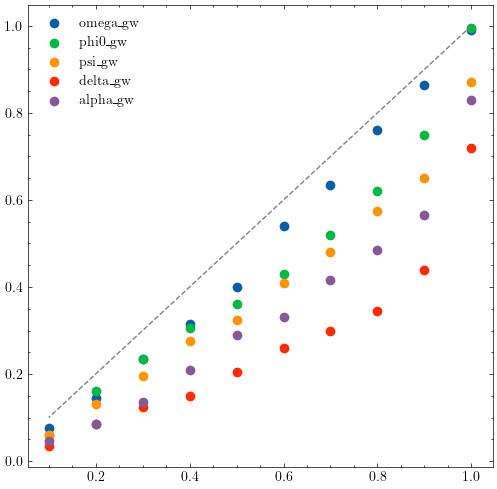

In [156]:
import matplotlib.pyplot as plt 
import scienceplots




plt.style.use('science')
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)


xx = np.arange(1,0.0,-0.1)

for i in range(len(variables_to_plot)):
    yy = quantile_results[:,i] / 200
    ax.scatter(xx,yy,label=variables_to_plot[i])

ax.legend()


ax.plot(xx,xx,linestyle = '--', c='0.5')


In [158]:
%%time
quantiles = np.arange(0,1.0,0.05) #[0.05,0.95] #90 per cent quantiles 
quantiles = np.append(quantiles,1.0) #quantiles.append(1.0)
import sys

#q90 = [0.05,0.95]
#q90_results = np.zeros(len(variables_to_plot))

quantile_results2 = np.zeros((int(len(quantiles)/2),len(variables_to_plot))) #quantile rows x variable columns

for f in list_of_files[0:1]:
    print(f)
    injection_parameters = parse_filename(f)
    # Load the data into a df
    f = open(f)
    data = json.load(f)
    f.close()
    df_posterior = pd.DataFrame(data["posterior"]["content"])[variables_to_plot] 
    
    #Get the quantiles
    df_quantile = df_posterior.quantile(quantiles)


    #For each quantile pair

    #Special case for i=0
    i=0
    lower_limit = df_quantile.iloc[i] 
    upper_limit = df_quantile.iloc[-1] 
 
    print("i = 0 quantile:", lower_limit, upper_limit)
    #print("quantiles", 0,quantiles[i], quantiles[-1],quantiles[-1] -quantiles[i])


    for j in range(len(injection_parameters)):
        var = variables_to_plot[j]
        #print(0, lower_limit[var], injection_parameters[j], upper_limit[var])
        if lower_limit[var] <= injection_parameters[j] <= upper_limit[var]:
            quantile_results[i,j] = quantile_results[i,j] + 1





    for i in range(1,int(len(quantiles)/2)):
        #print("quantiles", i,quantiles[i], quantiles[-i],quantiles[-i] -quantiles[i])

        lower_limit = df_quantile.iloc[i] 
        upper_limit = df_quantile.iloc[-i-1] #-1 since we are ignoreing the last element which was handled in the special case

        for j in range(len(injection_parameters)):
            var = variables_to_plot[j]
            if lower_limit[var] <= injection_parameters[j] <= upper_limit[var]:
                quantile_results2[i,j] = quantile_results[i,j] + 1


   


../data/nested_sampling/data_for_manuscript/pp_plots_small_h/pp_plot_h_5e-15_model_earth_seed_1237_omega_1.0196225038524221e-07_phi0_0.714870886742126_psi_0.9944870698629306_delta_1.2872050521677654_alpha_1.8515432419778288_result.json
i = 0 quantile: omega_gw    9.903419e-08
phi0_gw     1.018779e-01
psi_gw      2.190582e+00
delta_gw    1.249435e+00
alpha_gw    2.321323e+00
Name: 0.0, dtype: float64 omega_gw    1.060080e-07
phi0_gw     1.260344e+00
psi_gw      3.025393e+00
delta_gw    1.396771e+00
alpha_gw    3.141494e+00
Name: 1.0, dtype: float64
quantiles 1 0.05 1.0 0.95
quantiles 2 0.1 0.9500000000000001 0.8500000000000001
quantiles 3 0.15000000000000002 0.9 0.75
quantiles 4 0.2 0.8500000000000001 0.6500000000000001
quantiles 5 0.25 0.8 0.55
quantiles 6 0.30000000000000004 0.75 0.44999999999999996
quantiles 7 0.35000000000000003 0.7000000000000001 0.35000000000000003
quantiles 8 0.4 0.65 0.25
quantiles 9 0.45 0.6000000000000001 0.15000000000000008
CPU times: user 2.84 s, sys: 1.04 s

In [159]:
df_quantile 

,omega_gw,phi0_gw,psi_gw,delta_gw,alpha_gw
0.00,9.903419e-08,0.101878,2.190582,1.249435,2.321323
0.05,1.011847e-07,0.467998,2.452548,1.308175,2.651319
0.10,1.015339e-07,0.524012,2.499733,1.321957,2.701743
0.15,1.017347e-07,0.560480,2.532750,1.330377,2.737758
0.20,1.018902e-07,0.588531,2.564103,1.337566,2.769016
0.25,1.020192e-07,0.612061,2.594278,1.343195,2.796363
0.30,1.021412e-07,0.635266,2.621069,1.348378,2.821611
0.35,1.022510e-07,0.655280,2.646126,1.351929,2.846029
0.40,1.023643e-07,0.675098,2.670299,1.355673,2.869908
0.45,1.024601e-07,0.693751,2.695377,1.358879,2.892243


In [147]:
quantiles = np.arange(0,1.0,0.05) #[0.05,0.95] #90 per cent quantiles 
quantiles = np.append(quantiles,1.0) #quantiles.append(1.0)
for i in range(1,int(len(quantiles)/2)):
    print("quantiles", i,quantiles[i], quantiles[-i-1],quantiles[-i-1] -quantiles[i])

    # lower_limit = df_quantile.iloc[i] 
    # upper_limit = df_quantile.iloc[-i-1] 

    # print(i,lower_limit["omega_gw"],upper_limit["omega_gw"])

quantiles 1 0.05 0.9500000000000001 0.9
quantiles 2 0.1 0.9 0.8
quantiles 3 0.15000000000000002 0.8500000000000001 0.7000000000000001
quantiles 4 0.2 0.8 0.6000000000000001
quantiles 5 0.25 0.75 0.5
quantiles 6 0.30000000000000004 0.7000000000000001 0.4
quantiles 7 0.35000000000000003 0.65 0.3
quantiles 8 0.4 0.6000000000000001 0.20000000000000007
quantiles 9 0.45 0.55 0.10000000000000003


In [138]:
df_quantile

,omega_gw,phi0_gw,psi_gw,delta_gw,alpha_gw
0.00,9.473751e-08,0.000695,1.383396,0.000129,0.792918
0.05,9.606490e-08,0.157644,1.733701,0.036713,1.036512
0.10,9.644945e-08,0.219911,1.775966,0.059823,1.072184
0.15,9.671623e-08,0.266403,1.804091,0.077665,1.097268
0.20,9.692526e-08,0.301811,1.824927,0.093616,1.117820
0.25,9.709342e-08,0.331164,1.846043,0.109597,1.135612
0.30,9.724903e-08,0.359110,1.862359,0.124151,1.149473
0.35,9.739003e-08,0.384281,1.877656,0.137782,1.163410
0.40,9.754183e-08,0.410425,1.892284,0.152138,1.176327
0.45,9.770319e-08,0.435395,1.905421,0.164837,1.188129


In [118]:
for i in range(1,int(len(qnew)/2)):
    print("quantiles", i,qnew[i], qnew[-i],qnew[-i] -qnew[i])

quantiles 1 0.05 1.0 0.95
quantiles 2 0.1 0.9500000000000001 0.8500000000000001
quantiles 3 0.15000000000000002 0.9 0.75
quantiles 4 0.2 0.8500000000000001 0.6500000000000001
quantiles 5 0.25 0.8 0.55
quantiles 6 0.30000000000000004 0.75 0.44999999999999996
quantiles 7 0.35000000000000003 0.7000000000000001 0.35000000000000003
quantiles 8 0.4 0.65 0.25
quantiles 9 0.45 0.6000000000000001 0.15000000000000008


In [105]:
quantiles_new = np.delete(quantiles, 10, axis=0)

In [107]:
for i in range(int(len(quantiles_new)/2)):
    print("quantiles", i,quantiles_new[i], quantiles_new[-i],quantiles_new[-i] -quantiles_new[i])

quantiles 0 0.0 0.0 0.0
quantiles 1 0.05 1.0 0.95
quantiles 2 0.1 0.9500000000000001 0.8500000000000001
quantiles 3 0.15000000000000002 0.9 0.75
quantiles 4 0.2 0.8500000000000001 0.6500000000000001
quantiles 5 0.25 0.8 0.55
quantiles 6 0.30000000000000004 0.75 0.44999999999999996
quantiles 7 0.35000000000000003 0.7000000000000001 0.35000000000000003
quantiles 8 0.4 0.65 0.25
quantiles 9 0.45 0.6000000000000001 0.15000000000000008


In [96]:
for i in range(int(len(quantiles)/2)):
    print(quantiles[i], quantiles[-i],quantiles[-i] -quantiles[i])

0.0 0.0 0.0
0.05 0.9500000000000001 0.9
0.1 0.9 0.8
0.15000000000000002 0.8500000000000001 0.7000000000000001
0.2 0.8 0.6000000000000001
0.25 0.75 0.5
0.30000000000000004 0.7000000000000001 0.4
0.35000000000000003 0.65 0.3
0.4 0.6000000000000001 0.20000000000000007
0.45 0.55 0.10000000000000003


In [84]:
%%time
q90_results/10

CPU times: user 29 µs, sys: 0 ns, total: 29 µs
Wall time: 32.9 µs


array([0.6, 0.9, 0.6, 0.4, 0.4])

In [87]:
q90_results/200

array([0.865, 0.75 , 0.65 , 0.44 , 0.565])

In [62]:
dtmp.loc[0.05]

omega_gw    5.666316e-09
phi0_gw     2.301482e-01
psi_gw      2.079523e+00
delta_gw    8.373452e-01
alpha_gw    6.737613e-02
Name: 0.05, dtype: float64

In [63]:
dtmp

,omega_gw,phi0_gw,psi_gw,delta_gw,alpha_gw
0.05,5.666316e-09,0.230148,2.079523,0.837345,0.067376
0.95,1.428526e-08,1.172421,2.665543,1.106143,0.681643


In [70]:








    

#injection_parameters

omega_gw 1.0230135211683393e-08 5.666316125013677e-09 1.4285261253409139e-08
phi0_gw 0.3704171536650886 0.2301482451910942 1.1724207206342971
psi_gw 2.8305556812996406 2.079523434354083 2.6655429408612705
delta_gw 0.8065654642127479 0.8373452248734071 1.1061434585674124
alpha_gw 1.296128240812015 0.06737613287043862 0.6816429849159905


In [65]:
lower_limit 

omega_gw    5.666316e-09
phi0_gw     2.301482e-01
psi_gw      2.079523e+00
delta_gw    8.373452e-01
alpha_gw    6.737613e-02
Name: 0.05, dtype: float64

# Plot a specific result